In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
import statistics
import pickle 
%matplotlib inline


print(tf.__version__)

2.14.0


## Image analysis

Number of images: 1644
Mean: 104.99878345498783
Geometric mean: 91.36642048787509
Median: 81.0
Min: 48
Max: 711
Last non-outlier dimension: 193


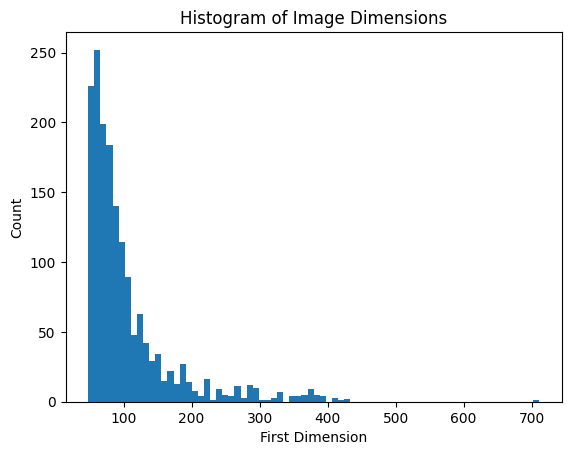

In [15]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        img = os.path.join(i, j)

        if "synthesized" in img:

            for synth in os.listdir(img):
                img3 = os.path.join(img, synth)

                img2 = Image.open(img3)
                img_array = np.array(img2)
                dimensions.append(img_array.shape[0])
                img_array = np.expand_dims(img_array, axis=-1)
        else:
            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

q1 = np.percentile(dimensions, 25)
q3 = np.percentile(dimensions, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
dimensions = np.sort(np.array(dimensions))
first_outlier = np.where((dimensions < q1 - threshold) | (dimensions > q3 + threshold))[0]
print("Last non-outlier dimension:", dimensions[first_outlier[0] - 1])


plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [16]:
confirmed_num = 0

confirmed_num += len(os.listdir(dirs[0]))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0

for filename in os.listdir(dirs[1]):
    if "synthesized" in filename:
        rejected_images += [
            os.path.join(dirs[1], filename, synth)
            for synth in os.listdir(os.path.join(dirs[1], filename))
        ]
    else:
        rejected_images.append(os.path.join(dirs[1], filename))

rejected_num = len(rejected_images)
print("Number of artifact images:", rejected_num)

Number of meteor images: 822
Number of artifact images: 822


## Class balancing using image augmentation


In [17]:
data_augmentation = tf.keras.Sequential(
    [
        # TODO: Modify data augmentation layers
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomZoom(0.2, 0.2),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    if "synthesized" in random_image_path:
        continue
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of meteor images:", confirmed_num)
print("Number of artifact images:", rejected_num)

Classes balanced.
Number of meteor images: 822
Number of artifact images: 822


## Dataset creation


In [18]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
# IMG_SIZE = first_outlier
BATCH_SIZE = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)

class_names = train_ds.class_names

Found 1644 files belonging to 2 classes.
Using 1151 files for training.
Using 493 files for validation.


### Dataset normalization


In [21]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    image = tf.image.per_image_standardization(image)

    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

dataset_name="20240412_1"
train_ds.save(f"datasets/{dataset_name}_train")
val_ds.save(f"datasets/{dataset_name}_val")


### Dataset visualization


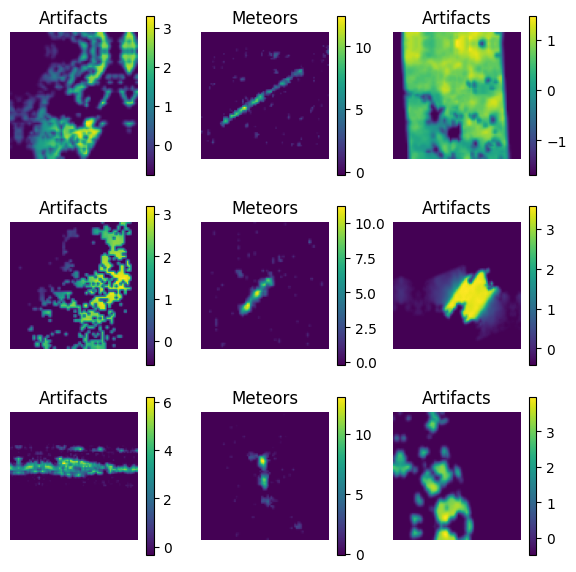

In [7]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

## Model creation


In [26]:
# model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133

model = models.Sequential()
model_name= "CNN_20240412_1"
model._name = model_name

# added by me, so that these normalization steps arent done before the model
# model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
# model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(8, (5, 5), activation="relu"))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.build((BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))

model.summary()

json_config = model.to_json()
with open(f'models/{model_name}_config.json', 'w') as json_file:
    json_file.write(json_config)
with open(f'models/{model_name}_config.json', 'r') as json_file:
    json_config = json_file.read()
model = keras.models.model_from_json(json_config)

Model: "CNN_script_20240412_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (32, 77, 77, 8)           208       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 15, 15, 8)           0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (32, 1800)                0         
                                                                 
 dense_8 (Dense)             (32, 16)                  28816     
                                                                 
 dense_9 (Dense)             (32, 1)                   17        
                                                                 
Total params: 29041 (113.44 KB)
Trainable params: 29041 (113.44 KB)
Non-trainable params: 0 (0.00 Byte)
_______

Model compiling and training


In [78]:
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(),
    metrics=[
        tf.keras.metrics.F1Score(name="f1",threshold=0.5,average="micro"),
    ],
)

In [79]:
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/10
36/36 [==============================] - 5s 94ms/step - loss: 0.2008 - mAP: 0.9662 - f1: 0.9380 - precision: 0.9191 - recall: 0.9578 - val_loss: 0.1589 - val_mAP: 0.9747 - val_f1: 0.9472 - val_precision: 0.9061 - val_recall: 0.9921
Epoch 2/10
36/36 [==============================] - 1s 18ms/step - loss: 0.1058 - mAP: 0.9861 - f1: 0.9645 - precision: 0.9505 - recall: 0.9789 - val_loss: 0.1030 - val_mAP: 0.9923 - val_f1: 0.9708 - val_precision: 0.9577 - val_recall: 0.9842
Epoch 3/10
36/36 [==============================] - 1s 16ms/step - loss: 0.0733 - mAP: 0.9919 - f1: 0.9792 - precision: 0.9674 - recall: 0.9912 - val_loss: 0.1009 - val_mAP: 0.9891 - val_f1: 0.9727 - val_precision: 0.9614 - val_recall: 0.9842
Epoch 4/10
36/36 [==============================] - 1s 16ms/step - loss: 0.0609 - mAP: 0.9951 - f1: 0.9808 - precision: 0.9724 - recall: 0.9895 - val_loss: 0.1121 - val_mAP: 0.9795 - val_f1: 0.9689 - val_precision: 0.9540 - val_recall: 0.9842
Epoch 5/10
36/36 [==========

In [31]:
model.save(f"models/{model_name}.keras")

Train results analysis


Validation mAP: 0.974
Validation F1-Score: [array([0.94716984], dtype=float32), array([0.9707602], dtype=float32), array([0.9726562], dtype=float32), array([0.9688716], dtype=float32), array([0.9649805], dtype=float32), array([0.9726562], dtype=float32), array([0.9706457], dtype=float32), array([0.96031743], dtype=float32), array([0.9668616], dtype=float32), array([0.9706457], dtype=float32)]


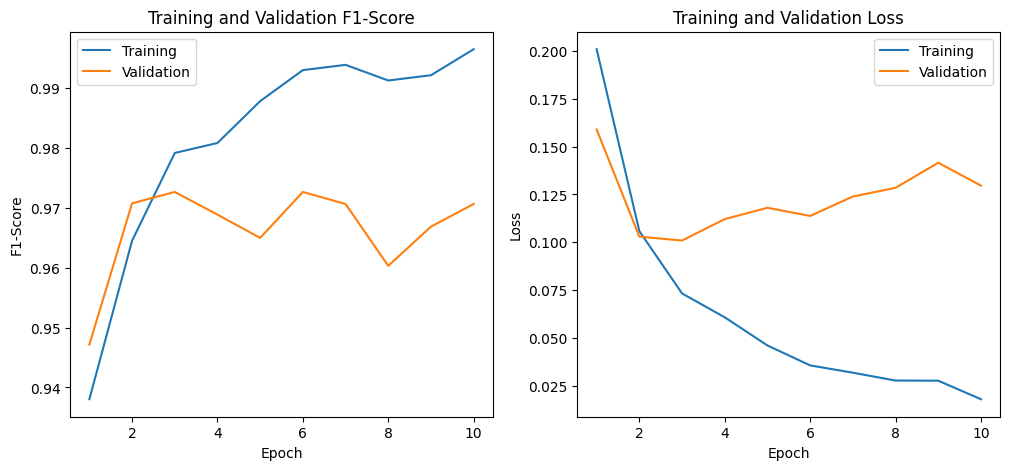

In [81]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
f1 = history.history["f1"]
val_f1 = history.history["val_f1"]

val_mAP = history.history["val_mAP"][-1]
print("Validation mAP:", round(val_mAP, 3))
print(
    "Validation F1-Score:",
    val_f1[-1][0],
)


epoch_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, f1, label="Training")
plt.plot(epoch_range, val_f1, label="Validation")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [82]:
Y_pred = model.predict(val_ds)

16/16 [==============================] - 0s 13ms/step


Confusion matrix


In [34]:
Y_pred_labels = np.squeeze(np.round(Y_pred))
# Y_pred_classes=binary_mtx = tf.where(Y_pred >= 0.9, 1, 0).numpy()

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_labels, num_classes=2)
print(confusion_mtx.numpy())

[[231   9]
 [ 12 241]]


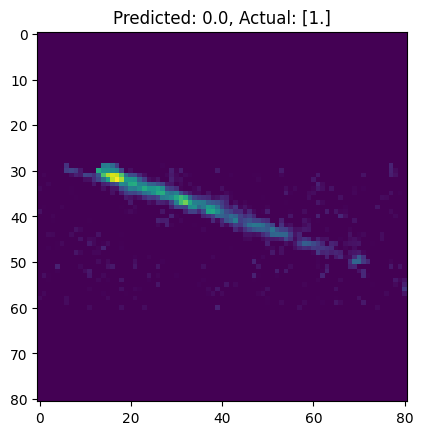

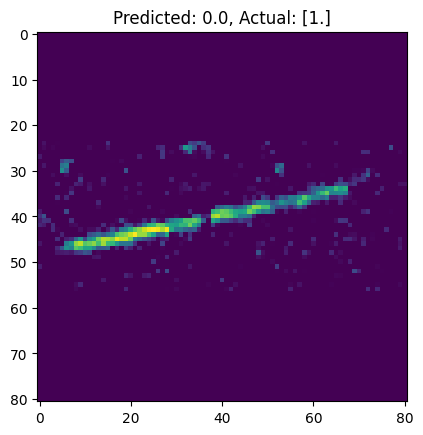

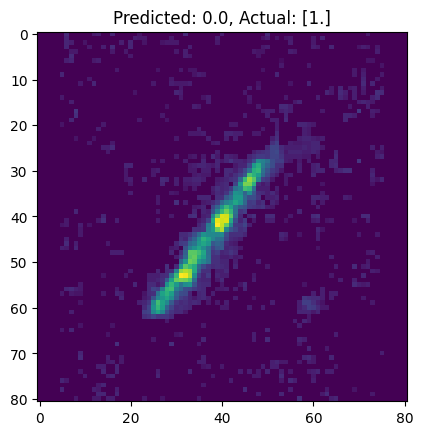

In [16]:
for i, (img, true_label) in enumerate(val_ds.unbatch()):
    if Y_pred_labels[i] == 0 and true_label == 1:
        plt.imshow(img)
        plt.title(f"Predicted: {Y_pred_labels[i]}, Actual: {true_label}")
        plt.show()

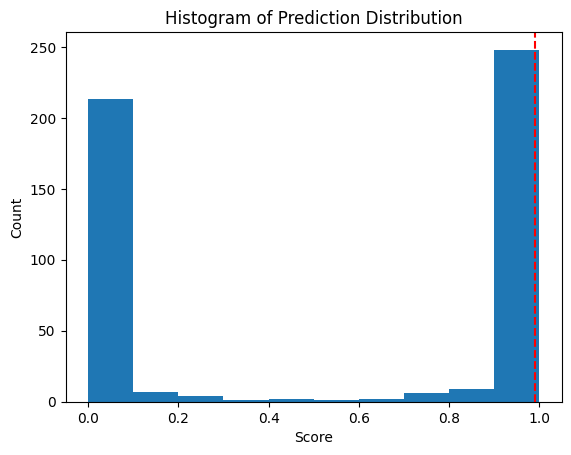

In [17]:
plt.hist(Y_pred, bins="auto")

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Histogram of Prediction Distribution")
plt.show()

Predicting a single example


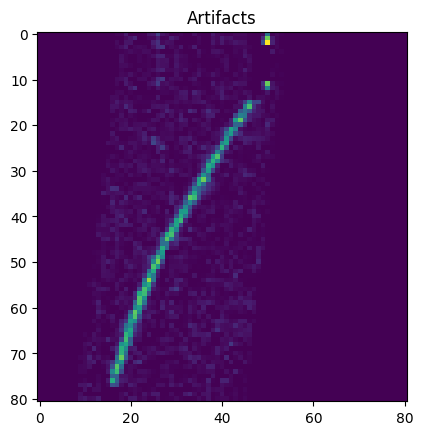

1/1 [==============================] - 0s 107ms/step
Prediction:           0.04777377471327782 - > True


In [19]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))] == class_names[int(lab[0])]}"
    )
    break

Testing Fiachra's model


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


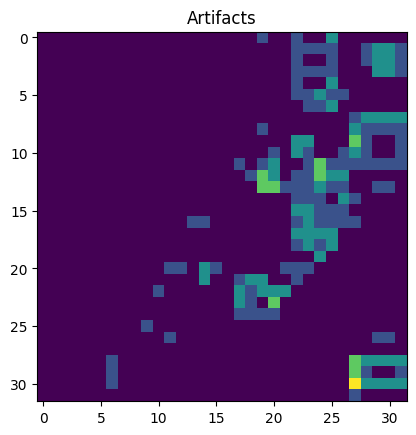

Prediction: 0 - > Artifacts == Artifacts


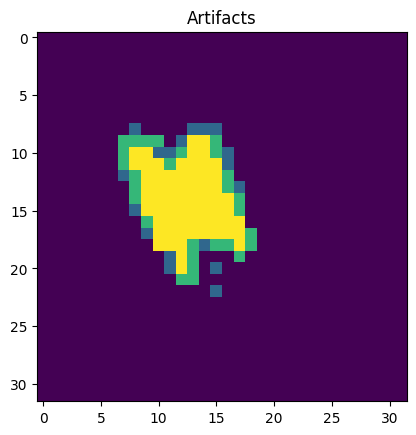

Prediction: 0 - > Artifacts == Artifacts


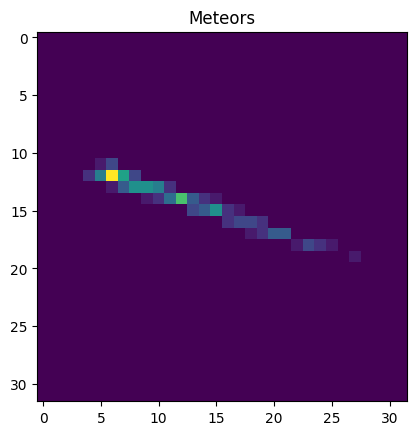

Prediction: 0 - > Artifacts == Meteors


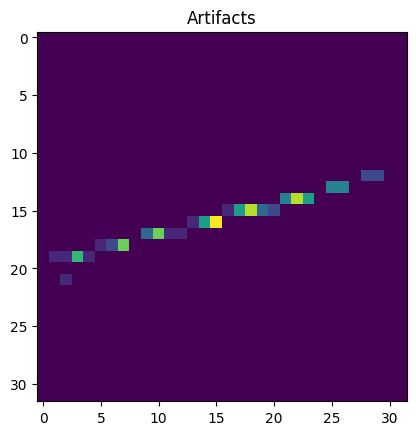

Prediction: 0 - > Artifacts == Artifacts


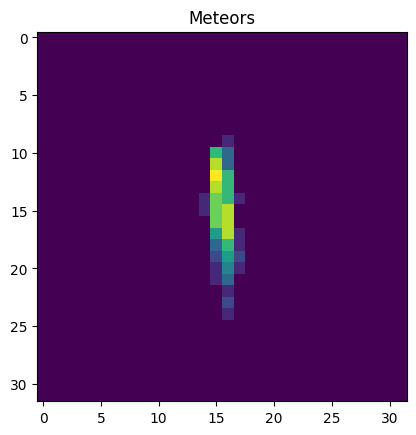

Prediction: 0 - > Artifacts == Meteors


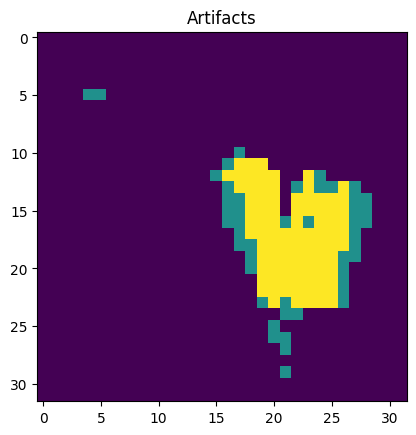

Prediction: 0 - > Artifacts == Artifacts


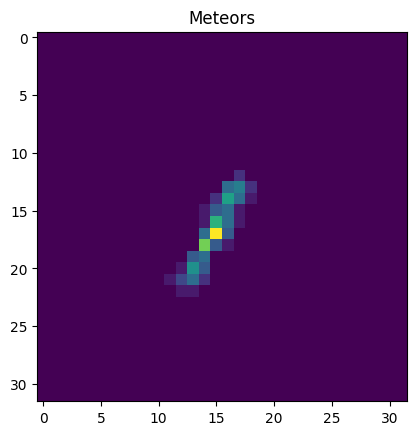

Prediction: 0 - > Artifacts == Meteors


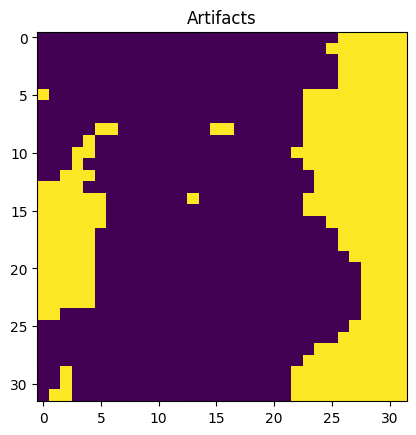

Prediction: 0 - > Artifacts == Artifacts


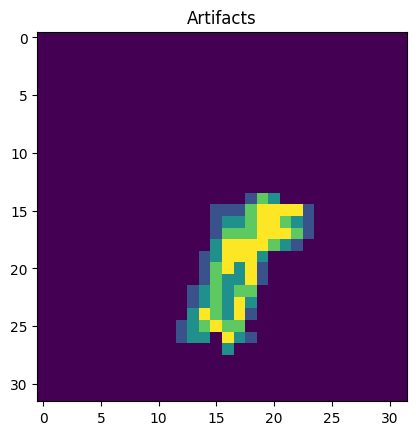

Prediction: 0 - > Artifacts == Artifacts


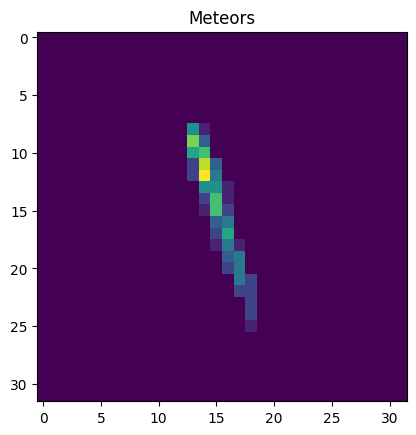

Prediction: 0 - > Artifacts == Meteors
Correct predictions: [145]
Test accuracy: [0.48172757]


In [20]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]
    # plt.figure()
    # img=resize_32(image_batch[0])
    # img=rescale(img)
    # img=image_batch[0]
    # print(img.numpy().max())
    # plt.imshow(img.numpy().astype("uint8"))
    # plt.title(f'{class_names[int(label_batch[0])]}')
    # plt.show()
    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        # print(output_data)
        prediction = np.argmax(output_data)  # Get the highest scoring class
        if i==image_batch.shape[0]-1:
                 
            plt.figure()
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(f'{class_names[int(label_batch[i])]}')
            plt.show() 
            print(f"Prediction: {prediction} - > {class_names[prediction]} == {class_names[int(label_batch[i])]}")
        correct_predictions += prediction == label_batch[i].numpy()
        # break
    # break

print("Correct predictions:", correct_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)